<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [2]:
!pip install --user sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
trans_df = pd.read_csv('data/arhuaco/BIBLIA.csv')
trans_df.rename(columns={"arh": "arhuaco"}, inplace = True)
print(trans_df.shape)
print(trans_df.columns)

(5563, 2)
Index(['esp', 'arhuaco'], dtype='object')


In [5]:
df_train, df_devtest = train_test_split(trans_df, test_size=2000, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=1000, random_state=42)

In [6]:
df_train.head()

,esp,arhuaco
2164,dejenlos crecer juntos hasta el tiempo de la s...,"ey uye'ki ase'ri 'unne'ki, kanu du nanu' ne..."
3906,en esto llegaron unos hombres que traian a un ...,"i'munu nungwa jesuri iku awin nuse'ri, uya'ba'..."
5482,puesto que amar a dios consiste en cumplir sus...,niwipaw riguzunhasuya kawari azey ga'kunamu un...
2879,"despues de esto, jesus subio al monte y llamo ...","ey uye'ki jesuse'ri chunun kinki, eyma ni nugw..."
355,"al llegar a la era de hatad, al otro lado del ...",ey awi jordan je yunuya muchey atad winkinkuma...


In [7]:
df_dev.head()

,esp,arhuaco
3213,"se dirigieron a cafarnaun y, cuando llego el s...","ey awi powru kapernaum ayeku unwinkikumeyri, s..."
179,"sara tuvo miedo, y lo nego diciendo yo no me...",sarari eymi no'kuye'ri chowchu kunasiri semu n...
3698,el segundo,"uweri i'munu nungwari, cheyrwa gunti koga wind..."
2948,cuando llego la gente y se pusieron a pedir a ...,"uye' kinka nunkuri i'ngwi barraba za'kinuga, g..."
5426,"al dia siguiente, los demas soldados regresaro...","ey awi asige'ri, soldadu kutun rizwein nu'na j..."


In [8]:
df_test.head()

,esp,arhuaco
1383,me acordare de la alianza que he establecido c...,ey unige'ri miwisin awiri pinna ana'nuga jinas...
3043,llevaron unos ninos a jesus para que los bendi...,"iwa a'mia gwakun, akusaw unchusiri, i'ngweygwi..."
1618,"en esto se le acerco un leproso, que se postro...","jesuri kugotin pari keywu kuchare'ri, iku sumu..."
252,pero el senor seguia estando con el y no dejo ...,"niwipawse' jose aguzanuyari, achwizunhasi igun..."
1832,el que los reciba a ustedes es como si me reci...,"iwa unhanugwe ikwawa yeykari, anizatikuma awun..."


# 2. How well does the data fit into a NLLB tokenizer?

In [9]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [10]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

In [11]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [12]:
smpl = df_train.sample(10000, random_state=42, replace=True)

smpl['esp_toks'] = smpl.esp.apply(tokenizer.tokenize)
smpl['arhuaco_toks'] = smpl.arhuaco.apply(tokenizer.tokenize)

smpl['esp_words'] = smpl.esp.apply(word_tokenize)
smpl['arhuaco_words'] = smpl.arhuaco.apply(word_tokenize)

In [13]:
smpl.sample(5)[['esp', 'esp_words', 'esp_toks', 'arhuaco', 'arhuaco_words', 'arhuaco_toks']]

,esp,esp_words,esp_toks,arhuaco,arhuaco_words,arhuaco_toks
4021,"decia, pues, juan a la mucha gente que venia p...","[decia, ,, pues, ,, juan, a, la, mucha, gente,...","[▁de, cia, ,, ▁pues, ,, ▁ju, an, ▁a, ▁la, ▁muc...","niwinha'gukun niwipawse' ga'si nakun nugari, p...","[niwinha, ', gukun, niwipawse, ', ga, ', si, n...","[▁ni, win, ha, ', g, ukun, ▁ni, wi, paw, se, '..."
4091,pero jesus les dijo por que se asustan y po...,"[pero, jesus, les, dijo, por, que, se, asustan...","[▁pero, ▁j, esus, ▁les, ▁dijo, ▁por, ▁que, ▁se...","uweri guna' awiri kuta nuchwa gun unki, uya ki...","[uweri, guna, ', awiri, kuta, nuchwa, gun, unk...","[▁uw, eri, ▁guna, ', ▁awiri, ▁kuta, ▁nu, ch, w..."
5245,"ahora bien, no existiendo una causa concreta d...","[ahora, bien, ,, no, existiendo, una, causa, c...","[▁ahora, ▁bien, ,, ▁no, ▁existi, endo, ▁una, ▁...",ey anuwe'ki inu juna keywu paperise'ri ka'si e...,"[ey, anuwe, ', ki, inu, juna, keywu, paperise,...","[▁ey, ▁anu, we, ', ki, ▁inu, ▁juna, ▁key, wu, ..."
1145,entonces abran cayo rostro en tierra mientras ...,"[entonces, abran, cayo, rostro, en, tierra, mi...","[▁entonces, ▁ab, ran, ▁c, ayo, ▁rost, ro, ▁en,...",ey uye' nungwari abrandi niwipawse' amasuya gu...,"[ey, uye, ', nungwari, abrandi, niwipawse, ', ...","[▁ey, ▁uye, ', ▁nung, wari, ▁ab, randi, ▁ni, w..."
2774,nosotros lo hemos oido afirmar yo derriba...,"[nosotros, lo, hemos, oido, afirmar, yo, derri...","[▁nosotros, ▁lo, ▁hemos, ▁o, ido, ▁afirmar, ▁y...",awi uya genunke'ri i'ngwi amusenajuri jesu uri...,"[awi, uya, genunke, ', ri, i, ', ngwi, amusena...","[▁awi, ▁uya, ▁gen, un, ke, ', ri, ▁i, ', ng, w..."


In [14]:
stats = smpl[['esp_toks', 'arhuaco_toks', 'esp_words', 'arhuaco_words']].applymap(len).describe()
stats

,esp_toks,arhuaco_toks,esp_words,arhuaco_words
count,10000.000000,10000.000000,10000.000000,10000.00000
mean,31.706400,53.138700,24.903000,33.23550
std,12.092825,21.817687,9.646652,13.95673
min,3.000000,0.000000,3.000000,0.00000
25%,23.000000,37.000000,18.000000,23.00000
50%,30.000000,51.000000,24.000000,32.00000
75%,39.000000,67.000000,31.000000,42.00000
max,88.000000,158.000000,69.000000,102.00000


In [15]:
print(stats.esp_toks['mean'] / stats.esp_words['mean'])
print(stats.arhuaco_toks['mean'] / stats.arhuaco_words['mean'])

1.2731960004818696
1.5988536354199574


In [16]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for arhuaco? If this is too often, we need to fix it somehow</p>

In [17]:
texts_with_unk = [text for text in tqdm(trans_df.arhuaco) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/5563 [00:00<?, ?it/s]

0


<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Adding a new language tag to the tokenizer and model</h1>

In [18]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [19]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

256204
['zul_Latn', '<mask>']


In [20]:
def fix_tokenizer(tokenizer, new_lang='arhuaco_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [21]:
fix_tokenizer(tokenizer)

In [22]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'arhuaco_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'arhuaco_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'arhuaco_Cyrl', '<mask>']
[256202, 256203, 256204]


In [23]:
added_token_id = tokenizer.convert_tokens_to_ids('arhuaco_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [24]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024)

In [25]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">4. Preparing the training loop</h1>

In [26]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [27]:
model.cuda();

In [28]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [29]:
batch_size = 8  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [30]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [31]:
LANGS = [('esp', 'spa_Latn'), ('arhuaco', 'arhuaco_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(item[l1])
        yy.append(item[l2])
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['el padre le dijo    hijo, tu siempre has estado conmigo, y todo lo mio es tuyo.'], [" ey awari ema mi gumusinu yunke' a'mia i'ngwi i'ngwi a'zunasin yow inu na'wenari unmintisa nikaki nuga jumena ki terneru ingumun chinchin kawa kugwa'na nisi ki zeywamu nisundi nunu'kwe   keywu key ie'ri."], 'spa_Latn', 'arhuaco_Cyrl')


In [32]:
MODEL_SAVE_PATH = 'models/nllb_arhuaco_BIBLIA-v1'

<h1 id="6.-The-training-loop">5. The training loop</h1>

In [33]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 8.262288093566895
1000 4.205297375679016
2000 2.9844522930383683
3000 2.5268596818447113
4000 2.1860665179491043
5000 1.9210373414754867
6000 1.6458241978287698
7000 1.4275820579230785
8000 1.2207466917634011
9000 1.065716643512249
10000 0.8896812225878239
11000 0.7517785842567682
12000 0.618858531832695
13000 0.5255429887548089
14000 0.4436873747110367
15000 0.3502091932222247
16000 0.3136780441515148
17000 0.2638420529179275
18000 0.21947381792590023
19000 0.19061088779754937
20000 0.16273187568038702
21000 0.1490146859381348
22000 0.13055593241378666
23000 0.1147056629974395
24000 0.10555755576677621
25000 0.09730565608851612
26000 0.09034605966508388
27000 0.08245903285313398
28000 0.07816053682658822
29000 0.0742310509281233
30000 0.06911830123420805
31000 0.0643245231602341
32000 0.06069818095676601
33000 0.05943953061290085
34000 0.05539607205335051
35000 0.051088717835955325
36000 0.04881711344886571
37000 0.04699355591088533
38000 0.0468025180385448
39000 0.04484240190638229

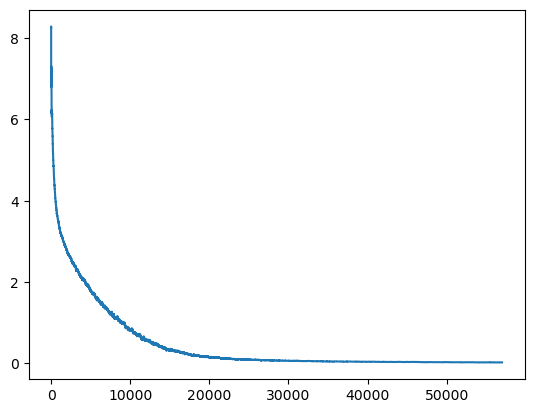

In [34]:
pd.Series(losses).ewm(100).mean().plot();

In [35]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [36]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

["ey uye'ri abraanse' eygwi key ie'ri     nupaw eymi mikuyukwey neki nuka'w nanunnuga eymikuyun nu'kwe'ri gwamu nukure'sow, uwe'ki mowga uga nukin zun iku kunuku neyka kwundi  key ie'ri     mowga uga kunuku neyka kawiri ayeygwi untesu' nunniza ni  niwipawse'ri kuyana."]
['abrahan siguio insistiendo   una vez mas me tomo el atrevimiento de dirigirme a mi senor. supongamos que se encuentran veinte.el senor respondio   por consideracion a esos veinte, no la destruire.']
['abrahan volvio a insistir yo pense que esta a la disposicion del senor, pero si tiene solamente doce en el nombre de los noventa y nueve, que al menos se encuentran las nueve en el reino de los cielos.']


In [37]:
!ls -alsh $MODEL_SAVE_PATH

total 2.3G
4.0K drwxr-xr-x 2 jovyan users 4.0K Nov 26 00:46 .
4.0K drwxr-xr-x 9 jovyan users 4.0K Nov 26 00:46 ..
4.0K -rw-r--r-- 1 jovyan users  896 Nov 26 04:00 config.json
4.0K -rw-r--r-- 1 jovyan users  184 Nov 26 04:00 generation_config.json
2.3G -rw-r--r-- 1 jovyan users 2.3G Nov 26 04:00 pytorch_model.bin
4.7M -rw-r--r-- 1 jovyan users 4.7M Nov 26 04:01 sentencepiece.bpe.model
4.0K -rw-r--r-- 1 jovyan users 3.5K Nov 26 04:01 special_tokens_map.json
4.0K -rw-r--r-- 1 jovyan users  570 Nov 26 04:01 tokenizer_config.json


<h1 id="6.-Using-the-model">6. Testing the model</h1>

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [39]:
def fix_tokenizer(tokenizer, new_lang='arhuaco_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [40]:
model_load_name = 'models/nllb_arhuaco_BIBLIA-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [41]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [42]:
t = "Hola como estas, ya hiciste la tarea de hoy"
print(translate(t, 'spa_Latn', 'arhuaco_Cyrl'))

["iwa nundi azi nuzoya awniza gun me'zari iwa sige' nikamu mikunchunha awniza gun me'zanundi."]


In [43]:
translate(t, 'spa_Latn', 'arhuaco_Cyrl', do_sample=True, num_beams=1, temperature=1.5)

['zana paw zu gumusinu nurizanundi du michukari ayey unchonunno.']

In [44]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [45]:
esp_translated = batched_translate(df_test.esp, src_lang='spa_Latn', tgt_lang='arhuaco_Cyrl')

  0%|          | 0/63 [00:00<?, ?it/s]

In [46]:
df_test['esp_translated'] = [translate(t, 'arhuaco_Cyrl', 'spa_Latn')[0] for t in tqdm(df_test.arhuaco)]
df_test['arhuaco_translated'] = [translate(t, 'spa_Latn', 'arhuaco_Cyrl')[0] for t in tqdm(df_test.esp)]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [48]:
print(bleu_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(chrf_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(bleu_calc.corpus_score(df_test['arhuaco_translated'].tolist(), [df_test['arhuaco'].tolist()]))
print(chrf_calc.corpus_score(df_test['arhuaco_translated'].tolist(), [df_test['arhuaco'].tolist()]))

BLEU = 7.03 29.6/7.6/4.0/2.7 (BP = 1.000 ratio = 1.031 hyp_len = 25776 ref_len = 25001)
chrF2++ = 24.88
BLEU = 5.81 25.1/7.3/3.4/1.8 (BP = 1.000 ratio = 1.010 hyp_len = 23711 ref_len = 23480)
chrF2++ = 30.77


In [49]:
pd.options.display.max_colwidth = 100

In [50]:
df_test.sample(10, random_state=42)[['arhuaco', 'esp', 'arhuaco_translated', 'esp_translated']]

,arhuaco,esp,arhuaco_translated,esp_translated
3626,"ey anunaju nungwa eygwi anunkamechuya jwin sawruba'ri, jesuri sinagogase' iku awiun keywu chunna...","los maestros de la ley y los fariseos, que estaban buscando un motivo para acusar a jesus, se pu...","wintunhanachuka'ri sawruba' neki du a'kusukwey nanu' gun nare' kinkiri, jesuri sawruba' zun gunu...","y como tenia por costumbre, entro en la sinagoga un hombre enfermo de la mano."
5514,"unkwuya ki miguzari kwundi, unwichukwa'ba pari akwa unkwey anawkwa'ba anunkuzagi'narwa na zun ni...","sabemos que por amar a nuestros hermanos hemos pasado de la muerte a la vida, mientras que quien...","unhakwuya jina, unhakwuya jina nujwa'suyase' kinkiri wichukwa neykari achwizanu' nanungwari na'n...","el que este en la azotea no baje a la casa a recoger ninguna de sus cosas, ni entre sus bienes, ..."
4755,"ey uye' nungwari pedruri, tina' ki ey na'zano kwa kumurin re'kuwikumun nusi ey na'zuna kinki zun...","pedro fue tras el, sin saber con certeza si lo del angel era o no real a el le parecia todo un ...","ey uye' nungwa pedruse'ri, niwipaw zu gunamu warinzanuse' jwi ey yun na'me ki ey yunno a'zare'ri...","y, dirigiendose a el, le dijo tambien tu eres el hijo de dios, el dios de abrahan, el dios de is..."
4253,winumusesi wintonajuri jwejwe' nari keywu jirugakaku fr ft powru nuga gakun dunda zunanke'...,"y, echando mano a jesus, lo arrojaron fuera del pueblo y lo llevaron a un barranco de la montana...","jesuri wintona'juri, powruse' pari rina'na jinase' winukuwite una.jesuri i'ngwi cheyrwa nai neyk...","en cuanto a los apostoles, salieron de alli y corrieron a la orilla del lago, donde encontraron ..."
1840,"'iwa ma belen, juda ka'gumaku zanu,juda sakuku rinari winde'gukun nuga jinari,awa'rin minha'chwu...","tu, belen, en el territorio de juda, no eres en modo alguno la menor entre las ciudades importan...","ma nundi, belen ka'gumarigun jwi na'na nuga'ba nundi, judiw zu powru awunkawa izuna'ba nununin a...","miren, los envio en belen, en la region de juda,para que se aparecienten a los jefes de los sace..."
4882,"miwiri jesu ta izare'ri, anugwe dunari iapana gwi ki uye' winukuyana. uye'ki ikunha'se'ri ...",a quienes pregunto recibieron el espiritu santo cuando abrazaron la fe ni siquiera hemos oi...,uye' nungwari pedru awiri asin rinanun nu'na jinari eymi keywu winasayri anugwe dunari jesu ta w...,entonces algunos maestros de la ley se dijeron este blasfema.
3891,jesuri jiwu gakun kinki mowga barku ingukinte' kawa aroma cho neyka keywu chwana. waku wintosuya...,"subiendo a una de las barcas, rogo a su dueno, simon, que la apartara un poco de la orilla. lueg...","i'ngwi nungwari jesuri barku umun a'zuna keywu zoyanajuri, simon, i'ngwi ka'gumuse' akutusin yow...","entonces jesus se dirigio al lago a la orilla del lago, donde vivia dos barcas. los pescadores s..."
4035,ey uye'ki eroderi uwanu' ne nisi zoya'ba eygwi uya kawu anunka'siri juandi kunse' anukugaka jume...,"un dia, cuando todo el pueblo se estaba bautizando, tambien jesus fue bautizado. y mientras orab...","ey awi pinna iku powru muchey winkwuya jinari jesu neki jwa'su'gwin nunniko, ey awi niwipaw gwam...","cuando volvieron los apostoles, contaron a jesus todo lo que habian hecho. jn"
4449,uweri emari emey gunti zunneykari ma'keywa sientu asewa uga kugi' zakusana gun nundi. ey awi eym...,todo esto duro unos cuatrocientos cincuenta anos. despues los guio por medio de caudillos hasta ...,"eymi awi zun ma'keywa sientu asewa uga kugi' umun kugi' izariri, awi nungwari profeta ismaeri za...","en total enoc vivio unos cuatrocientos cincuenta anos, desde que dios hablo por el profeta israe..."
674,"ey ukwe'gwiri abimeleri, azey soldadu jina zu sakuku fikol za'kinugase' kuchwi keywu abraan chwu...",habito en el desierto de paran y su madre lo caso con una mujer egipcia.alianza entre abrahan y ...,"awiri enori muchey ka' tikiririsinke' rinayun nuse'ri, abraan awiri abimelesin inu arunha me'kus...","entonces abimelec, acompanado por fiquel, 